In [23]:
import pyodbc
# for basic operations
import numpy as np
import pandas as pd

# for visualizations
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
plt.style.use('fivethirtyeight')


# for market basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [47]:
# connect to SQL (1st step)

# establish an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
'Server=DESKTOP-1VJ4H95;'
'Database=AdventureWorks2012;'
'Trusted_Connection=yes;')


In [3]:
# now that the database is connected to python pull the data needed (2nd step)

# pull orderdate Region and revenue  from SQL (AdventureWorks Database)
# plug your SQL query inside the """ """
basket=pd.read_sql_query("""
-- QUERY FOR MARKET BASKET ANALYSIS
	SELECT 
	SSOD.SalesOrderID AS TransactionID
	,PPSC.Name AS Item
	FROM [Sales].[SalesOrderDetail] AS SSOD
	LEFT JOIN[Sales].[SalesOrderHeader] AS SSOH
	ON SSOD.SalesOrderID =SSOH.SalesOrderID
	LEFT JOIN[Production].[Product] AS PP
	ON SSOD.ProductID = PP.ProductID
	LEFT JOIN [Production].[ProductSubcategory] AS PPSC
	ON PP.ProductSubcategoryID =PPSC.ProductSubcategoryID
	WHERE SSOH.OnlineOrderFlag =1
	ORDER BY SSOD.SalesOrderID
	  
""", conn)

conn.close() # please close it after 


In [39]:
#let explore the data
basket.head()


(60398, 2)

In [5]:
#let us get the null value in our data
basket.isnull().sum()

TransactionID    0
Item             0
dtype: int64

In [6]:
# get the summary statistics
basket.describe()

,TransactionID
count,60398.000000
mean,61849.376304
std,8030.546758
min,43697.000000
25%,55560.000000
50%,62104.000000
75%,68650.000000
max,75123.000000


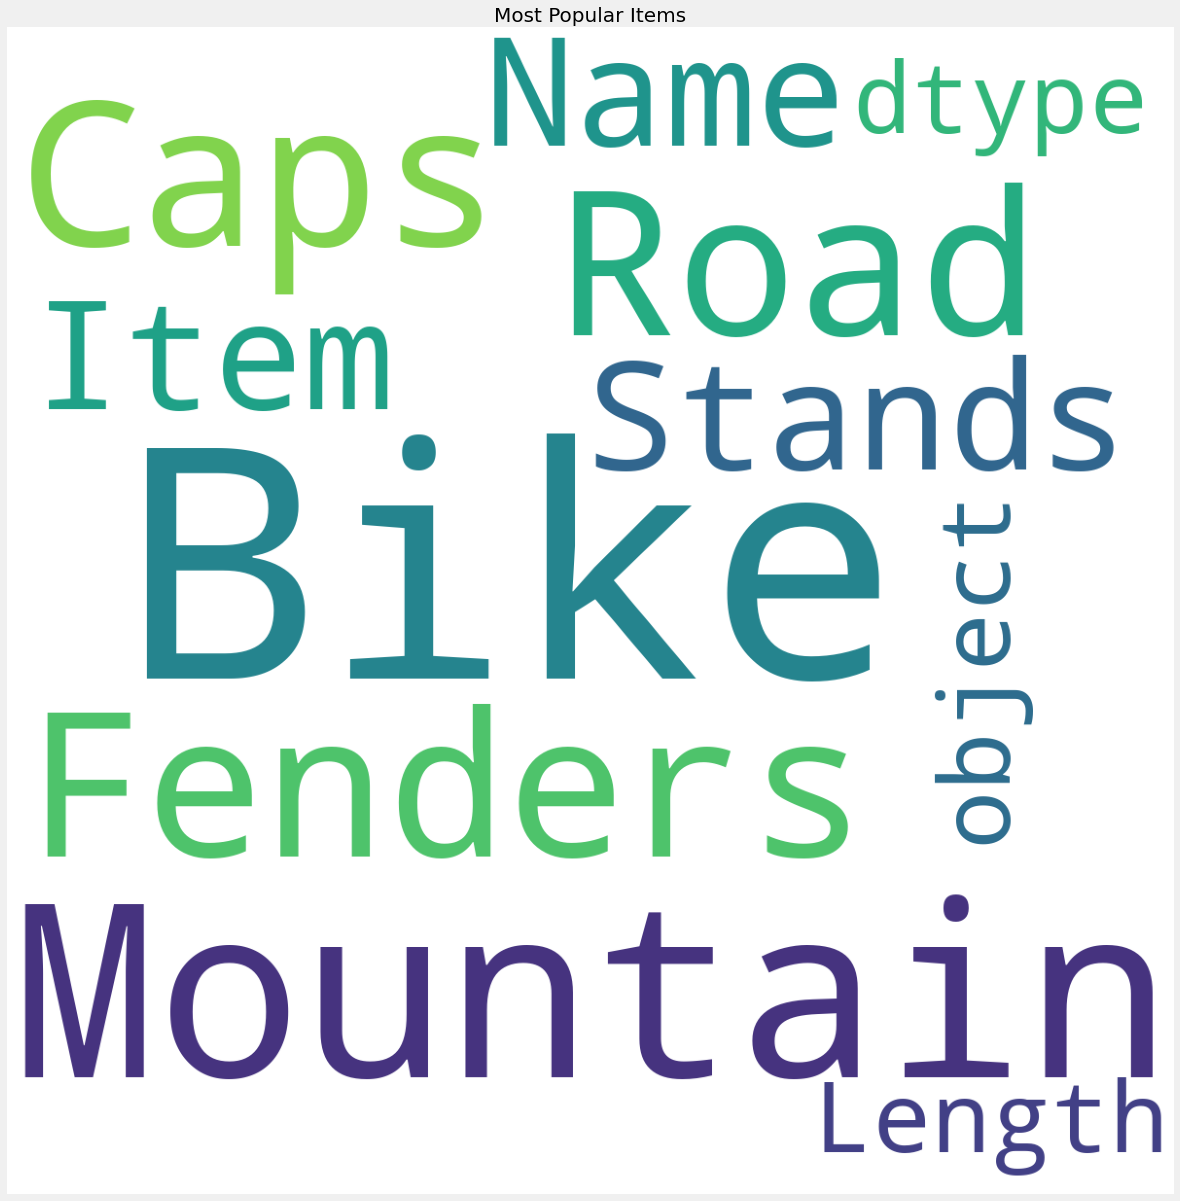

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (20, 20)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(basket['Item']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items',fontsize = 20)
plt.show()

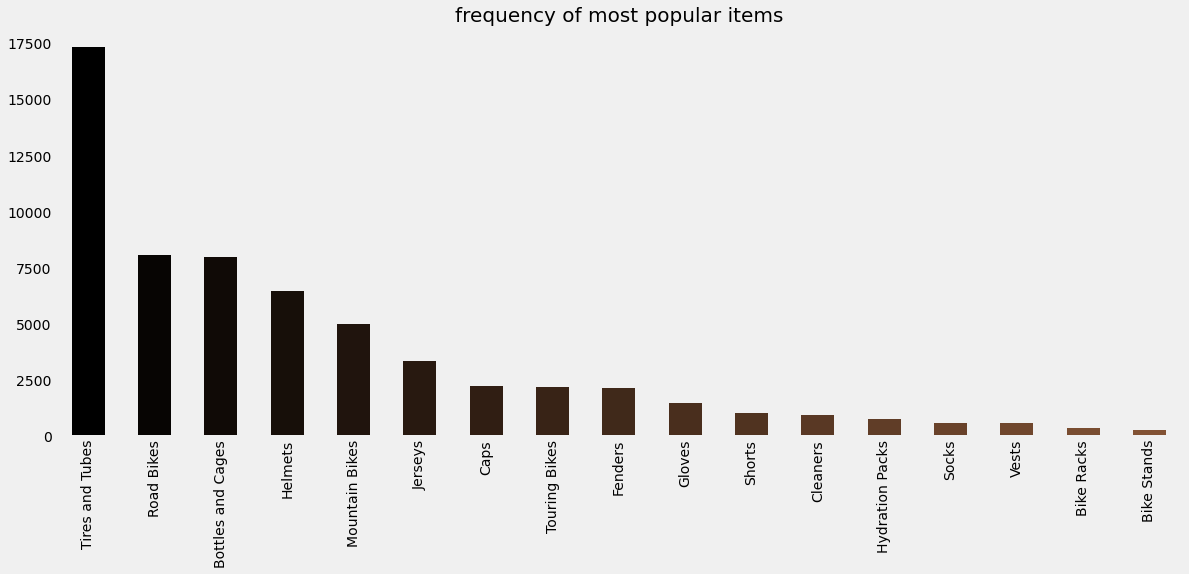

In [8]:
# looking at most popular item
# looking at the frequency of most popular items 

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
basket['Item'].value_counts().head(40).plot.bar(color = color)
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [9]:
basket['Item'].value_counts()

Tires and Tubes      17332
Road Bikes            8068
Bottles and Cages     7981
Helmets               6440
Mountain Bikes        4970
Jerseys               3332
Caps                  2190
Touring Bikes         2167
Fenders               2121
Gloves                1430
Shorts                1019
Cleaners               908
Hydration Packs        733
Socks                  568
Vests                  562
Bike Racks             328
Bike Stands            249
Name: Item, dtype: int64

In [10]:
# now let us plot the tree map for the most popular item
x=basket['Item'].value_counts().to_frame()
x.index

Index(['Tires and Tubes', 'Road Bikes', 'Bottles and Cages', 'Helmets',
       'Mountain Bikes', 'Jerseys', 'Caps', 'Touring Bikes', 'Fenders',
       'Gloves', 'Shorts', 'Cleaners', 'Hydration Packs', 'Socks', 'Vests',
       'Bike Racks', 'Bike Stands'],
      dtype='object')

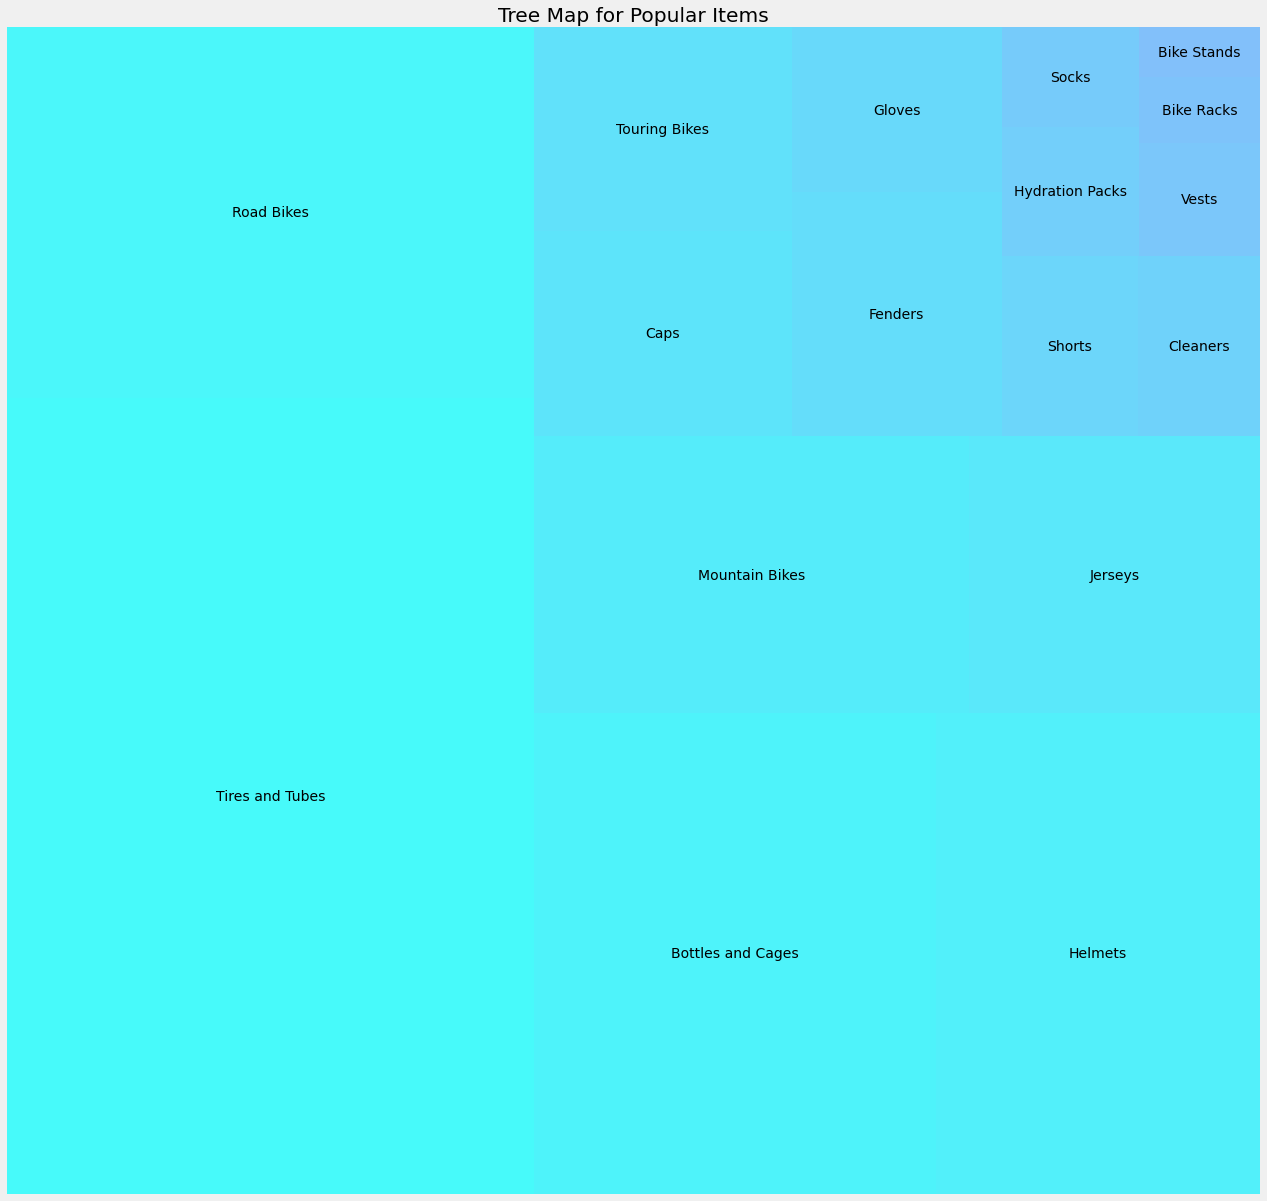

In [11]:
# plotting a tree map

plt.rcParams['figure.figsize'] = (20, 20)
color = plt.cm.cool(np.linspace(0, 1, 50))
squarify.plot(sizes =x.values, label = x.index, alpha=.7, color = color)
plt.title('Tree Map for Popular Items')
plt.axis('off')
plt.show()

## One-Hot Encoding

#### The Apriori function in the MLxtend library expects data in a one-hot encoded pandas DataFrame. This means that all the data for a transaction must be included in one row and the items must be one-hot encoded.

##### Therefore, we'll need to group the bread dataframe by Transaction and Item and display the count of items. Then we need to consolidate the items into one transaction per row with each item one-hot encoded.

In [12]:
df_grouped = basket.groupby(["TransactionID","Item"]).size().reset_index(name="Count")

df_grouped.head()

,TransactionID,Item,Count
0,43697,Road Bikes,1
1,43698,Mountain Bikes,1
2,43699,Mountain Bikes,1
3,43700,Road Bikes,1
4,43701,Mountain Bikes,1


In [13]:
my_basket = (df_grouped.groupby(['TransactionID', 'Item'])['Count']
          .sum().unstack().reset_index().fillna(0)
          .set_index('TransactionID'))

my_basket.head()

Item,Bike Racks,Bike Stands,Bottles and Cages,Caps,Cleaners,Fenders,Gloves,Helmets,Hydration Packs,Jerseys,Mountain Bikes,Road Bikes,Shorts,Socks,Tires and Tubes,Touring Bikes,Vests
TransactionID,,,,,,,,,,,,,,,,,
43697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
43699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
43700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
my_basket.shape

(27659, 17)

##### Note: At this stage, the one-hot encoded table shows the count of items purchased so we need to change it to 0 or 1 in case we have values greater than 1 because that is what apriori algorithm work with and 1 represent item in the basket and 0 not in the basket


In [15]:
# the encoding function
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [16]:
my_basket_sets = my_basket.applymap(encode_units)

my_basket_sets.head()

Item,Bike Racks,Bike Stands,Bottles and Cages,Caps,Cleaners,Fenders,Gloves,Helmets,Hydration Packs,Jerseys,Mountain Bikes,Road Bikes,Shorts,Socks,Tires and Tubes,Touring Bikes,Vests
TransactionID,,,,,,,,,,,,,,,,,
43697,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
43698,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
43699,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
43700,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
43701,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### Generate Frequent Itemsets

##### Now, we are ready to generate the frequent item sets. We will set the minimum-support threshold at 7 %

In [17]:
frequent_itemsets = apriori(my_basket_sets, min_support=0.04, use_colnames=True)

In [38]:
frequent_itemsets

,support,itemsets
0,0.172385,(Bottles and Cages)
1,0.079179,(Caps)
2,0.076684,(Fenders)
3,0.051701,(Gloves)
4,0.232836,(Helmets)
5,0.120467,(Jerseys)
6,0.179688,(Mountain Bikes)
7,0.291695,(Road Bikes)
8,0.356737,(Tires and Tubes)
9,0.078347,(Touring Bikes)


### Generate Association Rules

#### The final step is to generate the rules with their corresponding support, confidence and lift. We will set the minimum threshold for lift at 1 and then sort the result by descending confidence value.

In [32]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values("confidence", ascending = False, inplace = True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(Helmets),(Tires and Tubes),0.232836,0.356737,0.100004,0.429503,1.203976,0.016942,1.127548
2,(Tires and Tubes),(Helmets),0.356737,0.232836,0.100004,0.280328,1.203976,0.016942,1.065992
0,(Bottles and Cages),(Helmets),0.172385,0.232836,0.043422,0.251888,1.081826,0.003284,1.025467
1,(Helmets),(Bottles and Cages),0.232836,0.172385,0.043422,0.186491,1.081826,0.003284,1.017339


In [34]:
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(Helmets),(Tires and Tubes),0.232836,0.356737,0.100004,0.429503,1.203976,0.016942,1.127548
2,(Tires and Tubes),(Helmets),0.356737,0.232836,0.100004,0.280328,1.203976,0.016942,1.065992
0,(Bottles and Cages),(Helmets),0.172385,0.232836,0.043422,0.251888,1.081826,0.003284,1.025467
1,(Helmets),(Bottles and Cages),0.232836,0.172385,0.043422,0.186491,1.081826,0.003284,1.017339


In [48]:
# now that the database is connected to python pull the data needed (2nd step)

# pull orderdate Region and revenue  from SQL (AdventureWorks Database)
# plug your SQL query inside the """ """
Mba_Impact=pd.read_sql_query("""
-- QUERY FOR MARKET BASKET ANALYSIS -- GET ECONOMIC IMPACT OF MBA
	SELECT 
	--SSOD.SalesOrderID AS TransactionID
	--FORMAT (SSOH.OrderDate, 'MMMM') AS OrderDate
	PPSC.Name AS Item
	,count(SSOD.SalesOrderID) TransactionCount
	,avg(SSOD.UnitPrice) as Avg_Unitprice
	,sum(ssod.LineTotal)as Revenue
	FROM [Sales].[SalesOrderDetail] AS SSOD
	LEFT JOIN[Sales].[SalesOrderHeader] AS SSOH
	ON SSOD.SalesOrderID =SSOH.SalesOrderID
	LEFT JOIN[Production].[Product] AS PP
	ON SSOD.ProductID = PP.ProductID
	LEFT JOIN [Production].[ProductSubcategory] AS PPSC
	ON PP.ProductSubcategoryID =PPSC.ProductSubcategoryID
	WHERE (SSOH.OnlineOrderFlag =1 and ppsc.Name in('Helmets','Tires and Tubes'))
	group by PPSC.Name
	  
""", conn)

conn.close() # please close it after 


In [49]:
Mba_Impact

,Item,TransactionCount,Avg_Unitprice,Revenue
0,Helmets,6440,34.9900,225335.60
1,Tires and Tubes,17332,14.1662,245529.32
